<a href="https://colab.research.google.com/github/yanglinjing/dsnd_p3_identify_customer_segments/blob/master/Identify_Customer_Segments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Identify Customer Segments




## Introduction
The real-life data in this project concerns a company that performs mail-order sales in Germany, provided by AZ Direct and Arvato Finance Solution.

The goal of this project is to identify facets of the population that are most likely to be purchasers of their products for a mailout campaign. Unsupervised learning techniques are used to organize the general population into clusters for checking which of them comprise the main user base for the company. 

There are a few steps of data cleaning before the machine learning techniques have been applied.

### Data

The main data for this project consist of two files:

- `Udacity_AZDIAS_Subset.csv`: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- `Udacity_CUSTOMERS_Subset.csv`: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The **columns** in the *general* demographics file and *customers* data file are the
**same**. 

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their **household**, **building**, and **neighborhood**. 

### Features
There are another two documents explaining features:

- `AZDIAS_Feature_Summary.csv`: Summary of  demographics data 
       features; 85 features (rows) x 4 columns

- `Data_Dictionary.md`: Detailed information file about the 
       features

#### Latent Features

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level features
 7. RR1 neighborhood features
 8. PLZ8 macro-cell features
 9. Community-level features

In [10]:
# All the documents are stored on Google Drive.
# It requires authorisation before use them.
# This chunk of code is about authorisation.

# Mounting Google Drive locally
# https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
!pwd

/content


In [12]:
# CPU!!! --gdrive
#google colab - change path to google drive

import os 
os.chdir('gdrive/My Drive/Colab Notebooks/dsnd_p3_identify_customer_segments')
!pwd

/content/gdrive/My Drive/Colab Notebooks/dsnd_p3_identify_customer_segments


In [145]:
!ls data

AZDIAS_Feature_Summary.csv  Udacity_AZDIAS_Subset.csv
data_dictionary.ipynb	    Udacity_CUSTOMERS_Subset.csv
Data_Dictionary.md


In [0]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

In [0]:
my_color = ['#42bff4', '#f9ace9']

## Step 0: Load the Data

You will use this information to **cluster** the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset **fit** into those created clusters. 

The hope here is that certain clusters are*** over-represented*** in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.



To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary.

> **Tip**:  Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 


#### General Demographics Data

In [0]:
# Load in the general demographics data.
azdias = pd.read_csv('data/Udacity_AZDIAS_Subset.csv', sep = ';')

In [149]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.sample(1)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
356998,-1,2,1,4.0,3,3,3,2,2,2,...,1.0,3.0,3.0,2.0,4.0,3.0,2.0,5.0,7.0,5.0


In [150]:
azdias.shape

(891221, 85)

In [151]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

#### Feature Summary File

In [0]:
# Load in the feature summary file.
feat_info = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep = ';')
feat_info.set_index('attribute', inplace=True)

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

First of all, you should **assess** the demographics data in terms of missing data. 



#### Step 1.1.1: Convert Missing Value Codes to NaNs
The **fourth** column of the **feature summary** (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate*** missing or unknown data***. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a **string** object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [0]:
# turn missing_or_unknown to list 
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

In [0]:
# Identify missing or unknown data values and convert them to NaNs.
# In 'feat_info', the column 'missing_or_unknown' (type: object) shows missing values (e.g. -1, XX)

for attrib, missing_values in zip(feat_info.index, feat_info['missing_or_unknown']):
    if missing_values[0] != '':
        for value in missing_values:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                value = int(value)
            azdias.loc[azdias[attrib] == value, attrib] = np.nan

#lstrip() -- Returns a copy of the string with leading characters removed
#isnumeric() -- checks whether the string consists of only numeric characters

In [0]:
df_new = azdias.copy()

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [0]:
# Calculate the percentage of missing values of each column
missing = df_new.isnull().sum()
missing = missing[missing > 0] / df_new.shape[0] *100
missing.sort_values(inplace = True)

# columns have more than 20% missing values
missing_20 = missing[missing >20]

In [157]:
print(f"{len(missing)} out of {df_new.shape[1]} columns contain missing values, from {round(missing[0], 2)}% to {round(missing[-1], 2)}%.")
print(f'{len(missing_20)} columns have more than 20% missing values.')


61 out of 85 columns contain missing values, from 0.32% to 99.76%.
6 columns have more than 20% missing values.


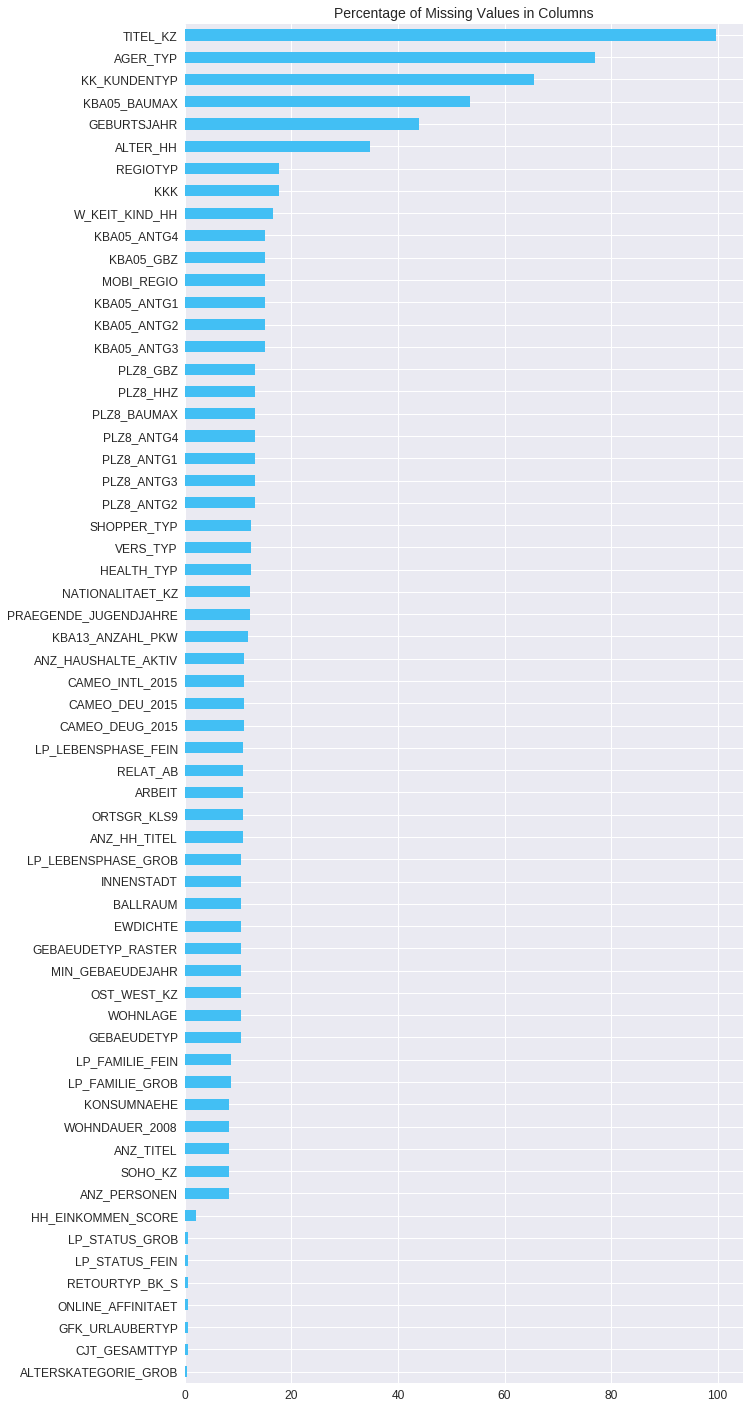

In [158]:
#Visualizing the naturally missing data
missing.plot.barh(figsize = (10, 25), fontsize = 12, color= my_color[0])
plt.title('Percentage of Missing Values in Columns', size = 14)
plt.show()

In [0]:
# Remove the outlier columns from the dataset / feature summary. 

# Drop columns that contain 20% missing values
for col in missing_20.index:
  
  # Dataset
  df_new.drop(col, axis = 1, inplace = True)
  
  # Feature Summary
  feat_info.drop([col], inplace = True)
  

In [160]:
df_new.shape, feat_info.shape

((891221, 79), (79, 3))

In [161]:
missing_20.index

Index(['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP',
       'TITEL_KZ'],
      dtype='object')

#### Discussion 1.1.2: Assess Missing Data in Each Column

61 out of 85 columns contain missing values, ranging from 0.32% to 99.76%. From the bar chart, it can be seen that the missing values of most columns are less than  20%, and the 6 columns at the top are outliers. Thus, they are removed from our dataset.

The columns removed from the dataset includes:

'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP',
       'TITEL_KZ'

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. 

Divide the data into two subsets: 
- one for data points that are **above** some threshold for missing values, and 
- a second subset for points **below** that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are **similar** or different* **bold text** between the two groups*. Select at least **five** of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [0]:
# How much data is missing in each row of the dataset?
missing_r = df_new.isnull().sum(axis=1)


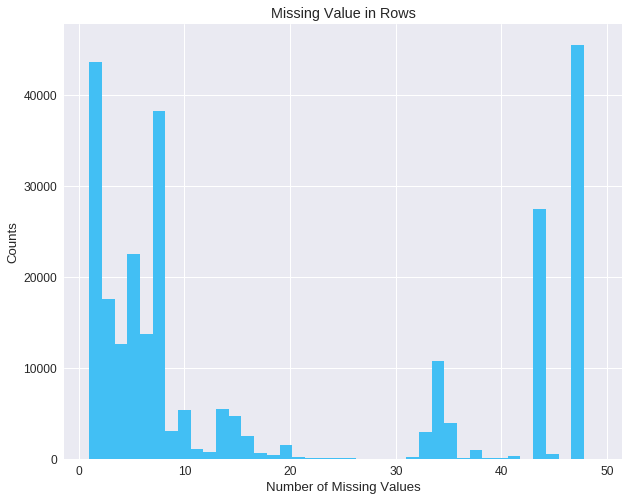

In [163]:
# Visualise
missing_r[missing_r > 0].plot(kind='hist', bins=40, figsize=(10,8), color=my_color[0])
plt.title('Missing Value in Rows')
plt.ylabel('Counts')
plt.xlabel('Number of Missing Values')
plt.show()

In [0]:
# Divide the data into two subsets: 10 missing values

df = df_new[missing_r <= 10]

df_more_missing = df_new[missing_r > 10]


In [0]:
def plot_comparison(df1, df2, n):
  
  cols = df1.columns.tolist()
  
  # Randomly reorder column names
  shuffle(cols) # shuffle works in place, and returns None
  
  for i in range(1, n+1):
    plt.figure(i, figsize=(12, 4))
    
    #subplot(nrows, ncols, index)
    plt.subplot(1, 2, 1)
    sns.countplot(x = df1[cols[i]], color = my_color[0], edgecolor='.9')
    plt.title(cols[i] + "(Data Kept)")

    plt.subplot(1, 2, 2)
    sns.countplot(x = df2[cols[i]], color = my_color[1], edgecolor='.9')
    plt.title(cols[i] + "(Data Rejected)")
    
    plt.subplots_adjust(wspace = 0.5)


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


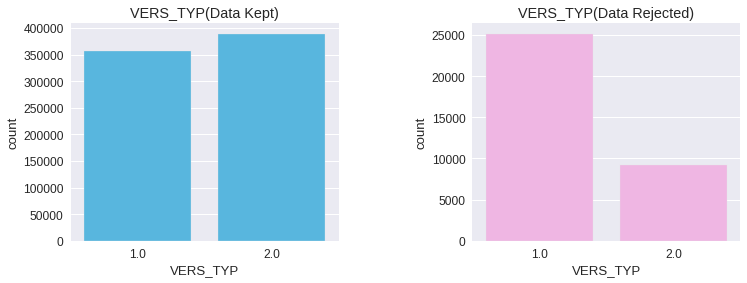

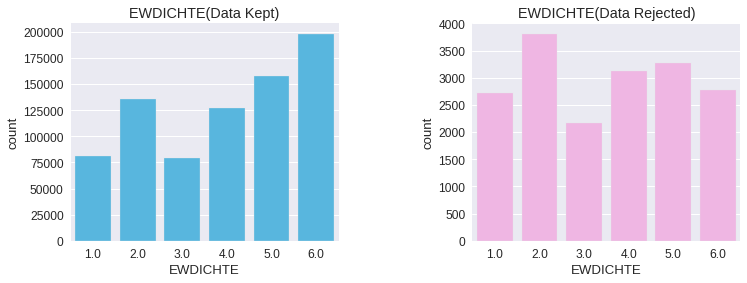

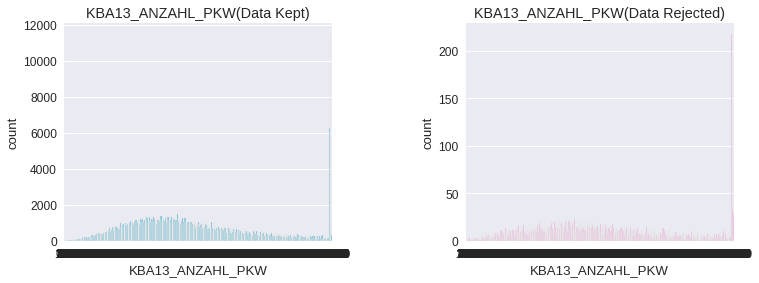

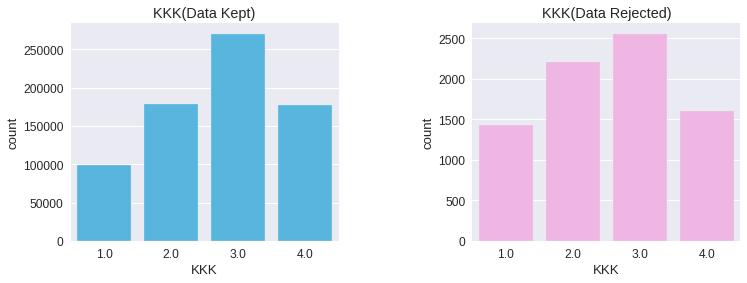

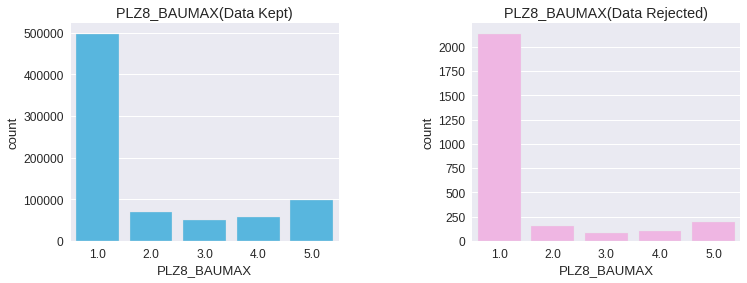

In [166]:
plot_comparison(df, df_more_missing, 5)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The distribution of some columns shows a significant difference between the two sub-datasets - with or without more than 10 missing values. Removing these column outliers could improve the effiency of our data.

### Step 1.2: Select and Re-Encode Features

Since the unsupervised learning techniques to be used will only work on data that is encoded **numerically**, you need to make a few encoding changes or additional assumptions to be able to make progress. 

In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the **third** column of the feature summary (`feat_info`) for a summary of types of measurement.
- For **numeric** and **interval** data, these features can be kept without changes.
- Most of the variables in the dataset are **ordinal** in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: **categorical**, and '**mixed**'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.


In [167]:
# How many features are there of each data type?
feat_info['type'].value_counts()


ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For **categorical** data, you would ordinarily need to encode the levels as **dummy** variables. Depending on the number of categories, perform one of the following:
- For binary (**two-level**) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on** non-numeric** values. For this one, you need to **re-encode** the values as numbers or create a dummy variable.
- For **multi-level** categoricals (three or more values), you can choose to encode the values using multiple **dummy** variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. 

As always, document your choices in the Discussion section.

##### Step 1.2.1.1

Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

In [0]:
# Put Categorical Features into a list
feat_cate = feat_info.query('type == "categorical"').index.tolist()

In [0]:
# build a df to show levels & types
feat_cate_df = pd.DataFrame(index = feat_cate, columns = ['levels', 'type'])

for feature in feat_cate:
  
  # number of levels
  levels = df[feature].value_counts().shape[0]
  
  # types
  feat_type = df[feature].dtypes
  
  # fill the df
  feat_cate_df.loc[feature] = [levels, feat_type]

In [170]:
feat_cate_df.sort_values('levels')

,levels,type
ANREDE_KZ,2,float64
OST_WEST_KZ,2,object
VERS_TYP,2,float64
SOHO_KZ,2,float64
GREEN_AVANTGARDE,2,int64
NATIONALITAET_KZ,3,float64
SHOPPER_TYP,4,float64
LP_STATUS_GROB,5,float64
LP_FAMILIE_GROB,5,float64
FINANZTYP,6,float64


##### Step 1.2.1.2
Re-encode categorical variable(s) to be kept in the analysis.

**Re-Encode Non-Numeric Binary Variable**

3.6. `OST_WEST_KZ` -- 
Building location via former East / West Germany (GDR / FRG)

- O: East (GDR)
- W: West (FRG)

In [171]:
# Re-encode 'OST_WEST_KZ': 2-level obj
# O: East (GDR)
# W: West (FRG)

df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'O': 0, 'W': 1})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [172]:
df['OST_WEST_KZ'].value_counts()

1    614719
0    165434
Name: OST_WEST_KZ, dtype: int64

**Simplify**

'GEBAEUDETYP'  has been simplified into 3 categories: 
- 1 = residential, 
- 2 = mixed usage, 
- 3 = commercial,

and then put into dummy variables.

The original 'GEBAEUDETYP' is:

3.3. `GEBAEUDETYP` -- Type of building (residential vs. commercial)
-  1: residential building
-  2: residential building buildings without actually known household
-  3: mixed (=residential and company) building
-  4: mixed building without actually known household or company
-  5: company building w/o known company
-  6: mixed building without actually known household
-  7: company building
-  8: mixed building without actually known compan

In [173]:
# Simplify 'GEBAEUDETYP' Type of building use into 3 categories; 1 = residential, 2 = mixed usage, 3 = commercial
df['GEBAEUDETYP'] = df['GEBAEUDETYP'].map({1:1,2:1,3:2,4:2,5:3,6:2,7:3,8:2})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [174]:
df['GEBAEUDETYP'].value_counts()

1    451603
2    328549
3         1
Name: GEBAEUDETYP, dtype: int64

**One-Hot-Encoding**

The following 7 columns have been put into dummy variables.

1.14. `LP_FAMILIE_GROB` --
Family type, rough scale

- 1: single (maps to 1 in fine scale)
- 2: couple (maps to 2 in fine scale)
- 3: single parent (maps to 3-5 in fine scale)
- 4: family (maps to 6-8 in fine scale)
- 5: multiperson household (maps to 9-11 in fine scale)

1.16. `LP_STATUS_GROB` -- Social status, rough scale

- 1: low-income earners (maps to 1-2 in fine scale)
- 2: average earners (maps to 3-5 in fine scale)
- 3: independents (maps to 6-7 in fine scale)
- 4: houseowners (maps to 8-9 in fine scale)
- 5: top earners (maps to 10 in fine scale)

1.17. `NATIONALITAET_KZ` -- Nationality based on given name analysis
-  1: German-sounding
-  2: foreign-sounding
-  3: assimilated names

1.21. `SHOPPER_TYP` -- Shopper typology
-  0: external supplied hedonists
-  1: Shopping-stressed
-  2: family-shopper
-  3: demanding shopper

1.4. `CJT_GESAMTTYP` -- 
Customer-Journey-Typology: preferred information and buying channels for consumer

- 1: Advertising- and Consumptionminimalist
- 2: Advertising- and Consumptiontraditionalist
- 3: advertisinginterested Store-shopper
- 4: advertisinginterested Online-shopper
- 5: Advertising- and Cross-Channel-Enthusiast
- 6: Advertising-Enthusiast with restricted Cross-Channel-Behaviour


1.6. `FINANZTYP` -- Most descriptive financial type for individual
-  1: low financial interest (MINIMALIST)
-  2: money-saver (SPARER)
-  3: home ownership (HAUSBAUER)
-  4: be prepared (VORSORGER)
-  5: investor (ANLEGER)
-  6: inconspicuous (UNAUFFAELLIGER)

4.1.` CAMEO_DEUG_2015`
German CAMEO: Wealth / Life Stage Typology, rough scale

- 1: upper class
- 2: upper middleclass
- 3: established middleclass
- 4: consumption-oriented middleclass
- 5: active middleclass
- 6: low-consumption middleclass
- 7: lower middleclass
- 8: working class
- 9: urban working class


In [0]:
df = pd.get_dummies(data = df, columns=['LP_FAMILIE_GROB', 
                                        'LP_STATUS_GROB', 
                                        'CJT_GESAMTTYP', 
                                        'CAMEO_DEUG_2015',
                                        'NATIONALITAET_KZ',
                                        'SHOPPER_TYP',
                                        'FINANZTYP',
                                        'GEBAEUDETYP'])

In [176]:
df.shape

(780153, 112)

**Drop Columns: **

The columns contains information that is  less important or similar to others are removed: 

- ZABEOTYP -- Energy consumption typology 
- LP_STATUS_FEIN (Similar as 1.16. LP_STATUS_GROB)
- LP_FAMILIE_FEIN -- Family type, fine scale (Similar as 1.14 LP_FAMILIE_GROB)
- GFK_URLAUBERTYP -- Vacation habits
- CAMEO_DEU_2015 -- Wealth / Life  (44 levels are too much)


In [0]:
df.drop(columns = ['ZABEOTYP', 
                   'LP_STATUS_FEIN',
                   'GFK_URLAUBERTYP', 
                   'LP_FAMILIE_FEIN', 
                   'CAMEO_DEU_2015' ], 
        inplace = True)

In [178]:
df.shape

(780153, 107)

#### Discussion 1.2.1: Re-Encode Categorical Features

1. The non-numeric binary variable, `OST_WEST_KZ`,  has been re-encoded by 0 and 1.

2. `GEBAEUDETYP` has been simplified into 3 categories, and then put into dummy variables.

3. The follwing columns have been directly put into dummy variables:

 - `LP_FAMILIE_GROB`
 - `LP_STATUS_GROB` 
 - `NATIONALITAET_KZ`
 -  `SHOPPER_TYP`
 - `CJT_GESAMTTYP`
 - `FINANZTYP`
 - ` CAMEO_DEUG_2015`

4. The following columns are removed as the information they contains is  less important or similar to others: 

 - `ZABEOTYP`
 - `LP_STATUS_FEIN`
 - `LP_FAMILIE_FEIN`
 - `GFK_URLAUBERTYP`
 - `CAMEO_DEU_2015`

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:

In [179]:
feat_info.query('type == "mixed"')

,information_level,type,missing_or_unknown
attribute,,,
LP_LEBENSPHASE_FEIN,person,mixed,[0]
LP_LEBENSPHASE_GROB,person,mixed,[0]
PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
WOHNLAGE,building,mixed,[-1]
CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


##### Step 1.2.2.1 PRAEGENDE_JUGENDJAHRE
"`PRAEGENDE_JUGENDJAHRE`" combines information on three dimensions: **generation** by decade, **movement** (mainstream vs. avantgarde), and **nation** (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.

1.18. **PRAEGENDE_JUGENDJAHRE**
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

- 1: 40s - war years (Mainstream, E+W)
- 2: 40s - reconstruction years (Avantgarde, E+W)
- 3: 50s - economic miracle (Mainstream, E+W)
- 4: 50s - milk bar / Individualisation (Avantgarde, E+W)
- 5: 60s - economic miracle (Mainstream, E+W)
- 6: 60s - generation 68 / student protestors (Avantgarde, W)
- 7: 60s - opponents to the building of the Wall (Avantgarde, E)
- 8: 70s - family orientation (Mainstream, E+W)
- 9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

New column

**DECADE**
- 1: 40s
- 2: 50s
- 3: 60s
- 4: 70s
- 5: 80s
- 6: 90s

In [0]:
#1 decade

df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6})

In [181]:
df['DECADE'].value_counts()

6.0    219439
4.0    171875
5.0    148118
3.0    113126
2.0     73441
1.0     27680
Name: DECADE, dtype: int64

New column:

**MOVEMENT**

- 0: Mainstream
- 1: Avantgarde

In [0]:
#2 movement

movement = []

for x in df['PRAEGENDE_JUGENDJAHRE']:
  if x in [1,3,5,8,10,12,14]:
    movement.append(0)
  elif x in [2,4,6,7,9,11,13,15]:
    movement.append(1)
  else:
    movement.append(np.nan)

df['MOVEMENT'] = movement

In [183]:
df['MOVEMENT'].value_counts()

0.0    581988
1.0    171691
Name: MOVEMENT, dtype: int64

In [0]:
df.drop(columns = ['PRAEGENDE_JUGENDJAHRE'], inplace = True)

In [185]:
df.shape

(780153, 108)

##### Step 1.2.2.1 CAMEO_INTL_2015
 "`CAMEO_INTL_2015`" combines information on two axes: **wealth** and **life stage**. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code

- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families & Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement

In [186]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

df['CAMEO_INTL_2015'].value_counts()

51    132853
41     91071
24     89200
14     61422
43     55836
54     45004
25     38860
22     32235
45     25771
13     25659
23     24280
55     23609
52     20388
34     18237
31     17853
15     16735
44     14593
12     12890
35     10212
32     10153
33      9636
Name: CAMEO_INTL_2015, dtype: int64

New column:

**WEALTH**
- 1: Poorer Households
- 2: Less Affluent Households
- 3:Comfortable Households
- 4: Prosperous Households 
- 5: Wealthy Households

In [0]:
#1 wealth

wealth = []

for x in df['CAMEO_INTL_2015']:
  
  x = float(x)
  
  if 10 < x < 16:
    wealth.append(5)
  elif 20 < x < 26:
    wealth.append(4)
  elif 30 < x < 36:
    wealth.append(3)
  elif 40 < x < 46:
    wealth.append(2)
  elif 50 < x < 56:
    wealth.append(1)
  else:
    wealth.append(np.nan)
    
df["WEALTH"] = wealth

In [191]:
df["WEALTH"].value_counts()

1.0    221854
2.0    187271
4.0    184575
5.0    116706
3.0     66091
Name: WEALTH, dtype: int64

New column:

**LIFE_STAGE**

- 1: Pre-Family Couples & Singles
- 2: Young Couples With Children
- 3: Families With School Age Children
- 4: Older Families & Mature Couples
- 5: Elders In Retirement

In [0]:
#2 life stage
life_stage = []

for x in df['CAMEO_INTL_2015']:
  
  x = float(x)
  
  if x % 10 == 1:
    life_stage.append(1)
  elif x % 10 == 2:
    life_stage.append(2)
  elif x % 10 == 3:
    life_stage.append(3)
  elif x % 10 == 4:
    life_stage.append(4)
  elif x % 10 == 5:
    life_stage.append(5)
  else:
    life_stage.append(np.nan)

df['LIFE_STAGE'] = life_stage

In [194]:
df['LIFE_STAGE'].value_counts()

1.0    241777
4.0    228456
3.0    115411
5.0    115187
2.0     75666
Name: LIFE_STAGE, dtype: int64

In [0]:
df.drop(columns = ['CAMEO_INTL_2015'], inplace = True)

In [196]:
df.shape

(780153, 109)

##### Step 1.2.2.3 WOHNLAGE
 "`WOHNLAGE`" combines information on two axes: **neighbourhood quality** and **rural flag**. 

3.7. WOHNLAGE
Neighborhood quality (or rural flag)

- 0: no score calculated
- 1: very good neighborhood
- 2: good neighborhood
- 3: average neighborhood
- 4: poor neighborhood
- 5: very poor neighborhood
- 7: rural neighborhood
- 8: new building in rural neighborhood

New columns:

RURAL:
- 0: urban
- 1: rural

In [0]:
df['RURAL'] = df['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})

In [198]:
df['RURAL'].value_counts()

0    598005
1    182148
Name: RURAL, dtype: int64

New columns:

NEIGHBOUR_QLT

- 0: no score calculated
- 1: very good neighborhood
- 2: good neighborhood
- 3: average neighborhood
- 4: poor neighborhood
- 5: very poor neighborhood

In [0]:
df['NEIGHBOUR_QLT'] = df['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})

In [200]:
df['NEIGHBOUR_QLT'].value_counts()

3    246155
0    185102
4    134022
2     98784
5     72899
1     43191
Name: NEIGHBOUR_QLT, dtype: int64

In [0]:
df.drop('NEIGHBOUR_QLT', axis = 1, inplace = True)

In [202]:
df.shape

(780153, 110)

 ##### Step 1.2.2.4 Drop other mixed columns
 
-  `LP_LEBENSPHASE_FEIN` and
 
-  `LP_LEBENSPHASE_GROB`
 
are dropped as the information they provide has already been included in other features.

- `PLZ8_BAUMAX` 

has been removed as this scale is ordinal from 1-4 with size of housing buildings, but 5 indicates business buildings.

In [0]:
df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX'], axis = 1, inplace = True )

In [204]:
df.shape

(780153, 107)

In [0]:
df.to_csv('data/azdias_new', index = False)

#### Discussion 1.2.2: Engineer Mixed-Type Features

The  mixed columns 'PRAEGENDE_JUGENDJAHRE'  has been separated into 2 new columns: 
- DECADE, 
- MOVEMENT,

while  'CAMEO_INTL_2015' becomes another 2:
- WEALTH, 
- LIFE_STAGE,

and 'NEIGHBOUR_QLT' has been divided into:

- 'RURAL',
- 'NEIGHBOUR_QLT'.

The original columns `PRAEGENDE_JUGENDJAHRE`, `CAMEO_INTL_2015`  and  `WOHNLAGE` have been removed from the dataset.


The other 3 columns `LP_LEBENSPHASE_FEIN`, `LP_LEBENSPHASE_GROB` and `PLZ8_BAUMAX`	were dropped as the information they provide has already been included in other features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main **feature selection**, **encoding**, and **re-engineering** steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [0]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
 
    # 1: Assess Missing Data
  
    # 1.1 Convert Missing Value Codes to NaNs
    df = convert_missing_value(df, feat_info)
    
    # 1.2 Assess Missing Data in Each Column
    df = drop_missing_col(df)
    
    # 1.3: Assess Missing Data in Each Row
    df = drop_missing_row(df)

    
    # 2: Select and Re-Encode Features
    cols = df.columns.tolist()
    
    # 2.1: Re-Encode Categorical Features
    df = encode_cate_feat(df, cols)
    
    # 2.2: Engineer Mixed-Type Features
    df = encode_mixed_feat(df, cols)
    
    # save
    df.to_csv('data/customer_new.csv', index = False)

    # Return the cleaned dataframe.
    return df

In [0]:
# 1.1.1 Convert Missing Value Codes to NaNs
def convert_missing_value(df, feat_info):
  
  # turn missing_or_unknown to list 
  feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
  
  # Identify missing or unknown data values and convert them to NaNs.
  for attrib, missing_values in zip(feat_info.index, feat_info['missing_or_unknown']):
      if missing_values[0] != '':
          for value in missing_values:
              if value.isnumeric() or value.lstrip('-').isnumeric():
                  value = int(value)
              df.loc[df[attrib] == value, attrib] = np.nan
  
  return df

In [0]:
# 1.1.2 Assess Missing Data in Each Column

def drop_missing_col(df):

  missing_20 = ['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ']
  
  # Drop columns that have been removed from genenral population data 
  # which contain 20% missing values
  
  for col in missing_20:
    df.drop(col, axis = 1, inplace = True)
  
  return df

In [0]:
# 1.1.3: Assess Missing Data in Each Row

def drop_missing_row(df):
  
  # Calculate the number of missing values of each row
  missing_r = df.isnull().sum(axis=1)
  
  # Drop rows that contain more than 5 missing values
  df_new = df[missing_r <= 5]
  
  return df_new

In [0]:
#1.2.1: Re-Encode Categorical Features

def encode_cate_feat(df, cols):
  
  #1 re-encode 2-level feature
  if 'OST_WEST_KZ' in cols:
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'O': 0, 'W': 1})
    
  #2 simplify
  df['GEBAEUDETYP'] = df['GEBAEUDETYP'].map({1:1,2:1,3:2,4:2,5:3,6:2,7:3,8:2})
    
  #3 re-encode multi-level features
  dummies = ['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CJT_GESAMTTYP', 
             'CAMEO_DEUG_2015', 'NATIONALITAET_KZ','SHOPPER_TYP',
             'FINANZTYP', 'GEBAEUDETYP']
  for dummy in dummies:
    if dummy in cols:
      df = pd.get_dummies(data = df, columns=[dummy])
  
  #4 drop features
  drop_fs = ['ZABEOTYP', 'LP_STATUS_FEIN', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'CAMEO_DEU_2015' ]
  for drop_f in drop_fs:
    if drop_f in cols:
      df.drop(drop_f, axis = 1,  inplace = True)
      
  return df

In [0]:
# 1.2.2: Engineer Mixed-Type Features

def encode_mixed_feat(df, cols):
  
  #Column 1
  if 'PRAEGENDE_JUGENDJAHRE' in cols:
    #1 decade
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6})
    
    #2 movement
    movement = []

    for x in df['PRAEGENDE_JUGENDJAHRE']:
      if x in [1,3,5,8,10,12,14]:
        movement.append(0)
      elif x in [2,4,6,7,9,11,13,15]:
        movement.append(1)
      else:
        movement.append(np.nan)

    df['MOVEMENT'] = movement
    
    # drop original column
    df.drop(columns = ['PRAEGENDE_JUGENDJAHRE'], inplace = True)
    
  
  #Column2
  if 'CAMEO_INTL_2015' in cols:

    wealth, life_stage = [], []

    #1 wealth
    for x in df['CAMEO_INTL_2015']:
      
      x = float(x)
      
      if 10 < x < 16:
        wealth.append(5)
      elif 20 < x < 26:
        wealth.append(4)
      elif 30 < x < 36:
        wealth.append(3)
      elif 40 < x < 46:
        wealth.append(2)
      elif 50 < x < 56:
        wealth.append(1)
      else:
        wealth.append(np.nan)

    df["WEALTH"] = wealth
    
    #2 life stage
    for x in df['CAMEO_INTL_2015']:
      
      x = float(x)
      
      if x % 10 == 1:
        life_stage.append(1)
      elif x % 10 == 2:
        life_stage.append(2)
      elif x % 10 == 3:
        life_stage.append(3)
      elif x % 10 == 4:
        life_stage.append(4)
      elif x % 10 == 5:
        life_stage.append(5)
      else:
        life_stage.append(np.nan)

    df['LIFE_STAGE'] = life_stage
    
    #drop
    df.drop(columns = ['CAMEO_INTL_2015'], inplace = True)
    
  #Column3
  if 'WOHNLAGE' in cols:
    df['RURAL'] = df['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})
    df['NEIGHBOUR_QLT'] = df['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})
    df.drop('NEIGHBOUR_QLT', axis = 1, inplace = True)
    
  #Drop Column 456
  drop_fs = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX'] 
  for drop_f in drop_fs:
    if drop_f in cols:
      df.drop(drop_f, axis = 1, inplace = True )
      
  return df

In [0]:
def load_feature_info(path):
  # Load in the feature summary file.
  feat_info = pd.read_csv(path, sep = ';')
  feat_info.set_index('attribute', inplace=True)
  
  return feat_info

In [0]:
feat_info = load_feature_info('data/AZDIAS_Feature_Summary.csv')
df = pd.read_csv('data/Udacity_CUSTOMERS_Subset.csv', sep = ';')


In [0]:
clean_data(df, feat_info)

In [0]:
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

## Step 2: Feature Transformation


### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data **not have missing values** in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [0]:
df = pd.read_csv('data/azdias_new.csv')

cols = df.columns.tolist()

In [0]:
# Impute Nan by mode
imputer = Imputer(strategy = 'most_frequent', axis = 0) # axis=0 impute along columns.
data = imputer.fit_transform(df)

# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Convert data to df
df = pd.DataFrame(data, columns = cols)

In [0]:
# exactly same as the code cell above - used for customer data later
def transform_data(df, cols):
  # Impute Nan by mode
  imputer = Imputer(strategy = 'most_frequent', axis = 0) # axis=0 impute along columns.
  data = imputer.fit_transform(df)
  
  # Apply feature scaling to the general population demographics data.
  scaler = StandardScaler()
  data = scaler.fit_transform(data)
  
  # Convert data to df
  df = pd.DataFrame(data, columns = cols)
  
  return df

In [0]:
#df.to_csv('data/azdias_new3.csv', index = False)

### Discussion 2.1: Apply Feature Scaling

As the majority of the features are categorical or ordinal, I chose mode instead of mean or median as imputing method.

StandardScale has been used for normalising.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [0]:
# define PCA function
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, 
    and provides back the results of the transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    #X = StandardScaler().fit_transform(data)
    
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

# This code cell is retrived from Udacity classroom

In [0]:
# plot 1

# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    #for i in range(num_components):
    #    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

    
# This code cell is retrived from Udacity classroom

In [0]:
# plot 2

# draw percentage of variance captured by each principal component
def plot_single_p(pca):
  
  # calculate percentage
  p_pca = pca.explained_variance_ratio_.tolist()
  
  # to df
  p_pca = pd.DataFrame(p_pca, columns = ['Percentage'])
  
  # draw
  fig, ax = plt.subplots(figsize = (16, 8))
  sns.set(style="whitegrid")
  sns.barplot(x=p_pca.index, y="Percentage", data=p_pca, ax=ax)

In [0]:
# Calculate cumulative percentage of variance captured by number of principal components
def calculate_cumulative_p(pca):
  
  # calculate percentage of variance captured by each principal component
  p = pca.explained_variance_ratio_.tolist()
  
  p_list = []

  for i in range(1, len(p)+1):
    p_sum = np.sum(p[:i])

    p_list.append(p_sum)

  return(p_list)

In [0]:
# plot 3

# draw cumulative percentage of variance
def plot_cumulative_p(pca):
  
  #calculate
  p_list = calculate_cumulative_p(pca)
  
  # print
  p = round(p_list[-1], 2) * 100
  print(f"The largest cumulative percentage is {p}% in this case.")
  
  # to df
  p_list = pd.DataFrame(p_list, columns = ['Cumulative Percentage'])

  # draw
  fig, ax = plt.subplots(figsize = (16, 8))
  sns.set(style="whitegrid")
  sns.barplot(x = p_list.index, 
              y = "Cumulative Percentage", 
              data = p_list, 
              ax = ax)
  


In [0]:
# Apply PCA to the data.
pca, X_pca = do_pca(df.shape[1], df)

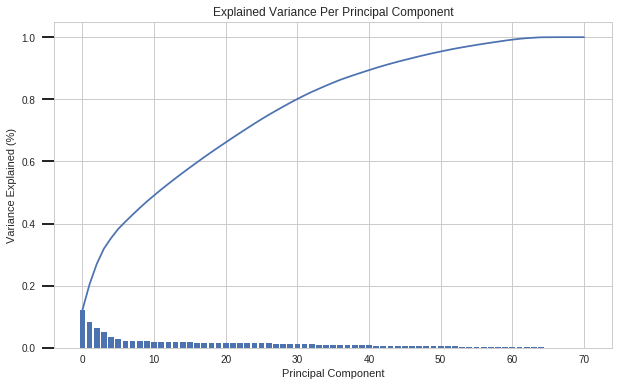

In [0]:
scree_plot(pca)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


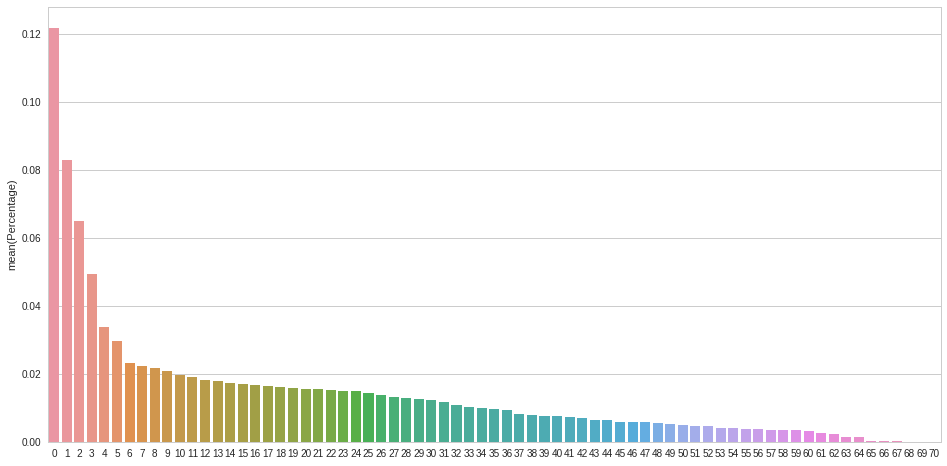

In [0]:
plot_single_p(pca)

The largest cumulative percentage is 100.0% in this case.


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


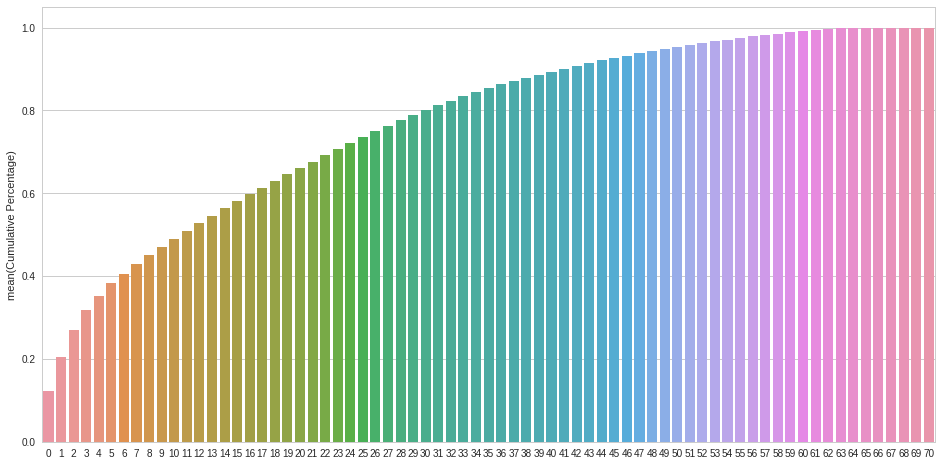

In [0]:
plot_cumulative_p(pca)

In [0]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, X_pca = do_pca(31, df)

In [0]:
X_pca = pd.DataFrame(X_pca) #(695553, 31)
#X_pca.to_csv('data/x_pca.csv', index = False)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


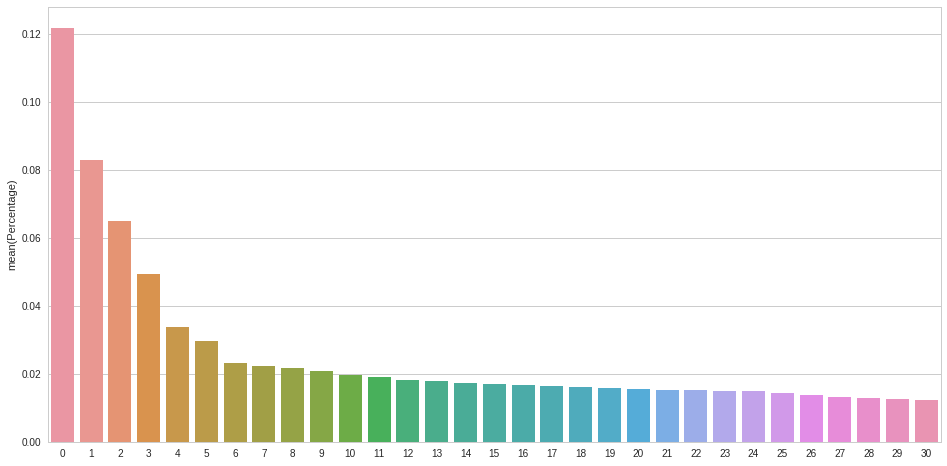

In [0]:
plot_single_p(pca)

The largest cumulative percentage is 80.0% in this case.


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


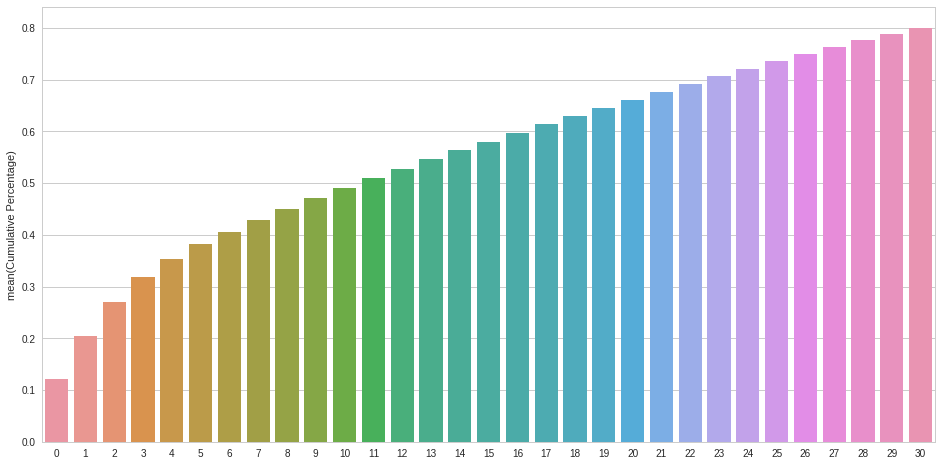

In [0]:
plot_cumulative_p(pca)

### Discussion 2.2: Perform Dimensionality Reduction

How many principal components / transformed features are you retaining for the next step of the analysis?

- I kept 31 principal components for furture analysis. The cumulative percentage variance contributed by them reaches 80.0%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the **weight** of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is **a unit vector** that points in the direction of highest **variance** (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the **same sign** (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with **different signs** can be expected to show **a negative correlation**: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each **weight** to their corresponding feature name, then **sort** the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a **positive or negative** value on the principal component might indicate.
- You should investigate and interpret **feature associations** from the** first three principal components** in this substep. To help facilitate this, you should write a **function** that you can call at any time to print the** sorted list of feature weights**, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [0]:
# Map weights for principal components to corresponding feature names

def create_weight_df(pca, cols):
  '''
  To build a dataframe containing weights & variance of pca
  
  cols - column names of df (general population)
  '''

  weights = pca.components_.tolist()
  variance = pca.explained_variance_ratio_.tolist()

  df = pd.DataFrame(weights, columns = cols)
  df['variance'] = variance

  return df

In [0]:
weight_df = create_weight_df(pca, cols)
weight_df.head(3)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,LP_STATUS_FEIN,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,...,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,DECADE,MOVEMENT,WEALTH,LIFE_STAGE,RURAL,variance
0,-0.108053,-0.233493,-0.079578,0.056970,-0.145883,-0.277261,-0.012007,0.051383,0.083914,0.131543,...,-0.000785,0.044812,0.119849,0.150317,0.114876,-0.145883,-0.244413,-0.150560,-0.151767,0.121914
1,0.263793,-0.005901,0.169820,0.049222,-0.022695,-0.059807,0.180815,-0.145569,-0.243574,-0.283959,...,0.015062,0.015380,0.052894,0.029743,-0.236819,-0.022695,-0.083908,-0.006533,-0.070428,0.083040
2,-0.140536,-0.116268,-0.105729,0.053033,-0.021944,-0.010241,-0.146116,-0.290000,-0.262504,0.023882,...,-0.002169,-0.007056,-0.029619,-0.041575,0.140897,-0.021944,0.061318,0.029572,0.023858,0.064992


In [0]:
def show_weight_pca(df, i, n):
  '''
  To print sorted list of feature weights 
  of a principle component.
  
  df - weight dataframe
  
  i - the [i] th principle component
  
  n - number of features
  
  '''
  negative = df.loc[i-1].sort_values()[:n]
  positive = df.loc[i-1].sort_values(ascending = False)[:n]
  
  variance = round(df.loc[i-1]['variance'], 4)
  
  print('-' * 32)
  print(f'Principal Component {i}')
  print('-' * 32)
  print(positive)
  print('-' * 32)
  print(negative)
  print('-' * 32)
  print(f'Variance = {variance}')
  print('\n')
  

In [0]:
# print feature weights of the first 3 principal components

for i in range(1, 4):
  show_weight_pca(weight_df, i, 5)

--------------------------------
Principal Component 1
--------------------------------
LP_STATUS_GROB_1.0    0.261493
ORTSGR_KLS9           0.204096
HH_EINKOMMEN_SCORE    0.201359
EWDICHTE              0.157874
PLZ8_ANTG2            0.156444
Name: 0, dtype: float64
--------------------------------
LP_STATUS_FEIN      -0.277261
MOBI_REGIO          -0.249377
WEALTH              -0.244413
FINANZ_MINIMALIST   -0.233493
KONSUMNAEHE         -0.176066
Name: 0, dtype: float64
--------------------------------
Variance = 0.1219


--------------------------------
Principal Component 2
--------------------------------
SEMIO_ERL               0.270816
ALTERSKATEGORIE_GROB    0.263793
SEMIO_LUST              0.254132
RETOURTYP_BK_S          0.180815
FINANZ_VORSORGER        0.169820
Name: 1, dtype: float64
--------------------------------
SEMIO_REL       -0.283959
SEMIO_PFLICHT   -0.263217
SEMIO_TRADV     -0.247329
SEMIO_FAM       -0.243574
DECADE          -0.236819
Name: 1, dtype: float64
---------

### Discussion 2.3: Interpret Principal Components

Can we interpret positive and negative values from them in a meaningful way?

- In principle component 1, `HH_EINKOMMEN_SCORE` with positive weight is on the opposite side of `WEALTH` with negative weight. If a household is richer, `HH_EINKOMMEN_SCORE` becomes lower, while `WEALTH` higher.

 - `HH_EINKOMMEN_SCORE`: Estimated household net income (1-highest, 6-lowest)
 - `WEALTH`: household wealth (1-poorer, 5-wealthy)

- In principle component 1,  both `LP_STATUS_FEIN` and `WEALTH` have negative weight. It can be seen that they have similar scoring methods - low score for poor people and high score for rich people.

 - `LP_STATUS_FEIN` - Social status, fine scale (1- typical low-income earners, 10: top earners)
 - `WEALTH`: household wealth (1-poorer, 5-wealthy)

## Step 3: Clustering



### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply** k-means clustering** to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the **PCA-transformed data**.
- Then, compute the **average difference** from each point to its assigned cluster's center. 

 - **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a **small**, toy dataset, or use an internet search to help your understanding.
 
- Perform the above two steps for a number of **different cluster counts**. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. 

 - **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through** at least 10 **clusters to get the full picture, but you **shouldn't **need to test for a number of clusters above about **30**.
 
- Once you've selected a final number of clusters to use, **re-fit** a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [0]:
X_pca = pd.read_csv('data/x_pca.csv') #X_pca - the transformed X matrix with 31 components

In [0]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters = center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [0]:
# Over a number of different cluster counts,
    # run k-means clustering on the data and
    # compute the average within-cluster distances.


scores = []
centers = list(range(1,30,2))

for center in centers:
  #print(center)
  score = get_kmeans_score(X_pca, center) 
  scores.append(score)

In [0]:
# show scores in df

scores_df = pd.DataFrame(data = {'centroid': centers, 'score': scores})
scores_df

,centroid,score
0,1,3.954473e+07
1,3,3.286782e+07
2,5,2.998774e+07
3,7,2.838247e+07
4,9,2.735236e+07
5,11,2.656309e+07
6,13,2.581582e+07
7,15,2.523873e+07
8,17,2.476606e+07
9,19,2.420208e+07


In [0]:
scores_df.to_csv('data/kmeans_score.csv', index = False)

In [0]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

def plot_kmeans_scores(centers, scores):
  plt.plot(centers, scores, 
           linestyle='--', marker='o', 
           color=my_color[0])
  
  plt.xlabel('K-centroids', fontsize = 12)
  plt.ylabel('Score - Sum of Squared Errors', fontsize = 12)
  plt.title('Relationship between \nSum of Squared Errors v.s. \nNumber of Centroids', size = 14)

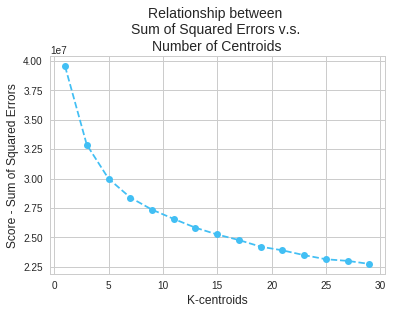

In [0]:
plot_kmeans_scores(centers, scores)

In [0]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.


#fit_predict - Compute cluster centers and predict cluster index for each sample.
kmeans_5 = KMeans(n_clusters = 5)
general_predict = kmeans_5.fit_predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

 Into how many clusters have you decided to segment the population?
 
 - From the plot, it is clear that the 'elbow' is at 5. Thus, I chose 5 as the number of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the **sklearn** objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [0]:
# cleaned customer data
df = pd.read_csv('data/customer_new.csv')

cols = df.columns.tolist()

In [0]:
#Impute Nan by mode
#Apply feature scaling: StandardScaler()

df = transform_data(df, cols)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
#transform the customers data using pca object (115420, 31)
df = pca.transform(df)

In [0]:
# Apply clustering from the general
# demographics onto the customer data, 
# obtaining cluster predictions for the
# customer demographics data.

customer_predict = kmeans_5.predict(df)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have **clustered data** based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be **universal**, then the cluster assignment proportions should be fairly **similar** between the two. 

- If there are **only particular** segments of the population that are interested in the company's products, then we should see a mismatch from one to the other.

- If there is a **higher proportion** of persons in a cluster for the **customer** data compared to the general population, then that suggests the people in that cluster to be a **target** audience for the company.
 - e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid

- On the other hand, the proportion of the data in a cluster being **larger** in the **general** population than the customer data suggests that group of persons to be** outside of the target **demographics.
 - e.g. only 2% of customers closest to a population centroid that captures 6% of the data

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the **ratios** in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are **overrepresented** in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. 
 - Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. 

 - Alternatively, you can use the `.inverse_transform()` method of the **PCA** and **StandardScaler** objects to transform centroids back to the** original data** space and interpret the retrieved values directly.
- Perform a similar investigation for the **underrepresented** clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [0]:
def build_cluster_df(prediction):
  '''
  To convert kmeans prediction result (array) to a dataframe
  '''
  x = np.array(prediction)
  cluster, counts = np.unique(x, return_counts=True)
  
  df = pd.DataFrame({'Cluster': cluster, 'Counts': counts})
  
  return df

In [0]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def concat_cluster_df(predict1, predict2):
  '''
  To compare 2 predictions - genenral vs customer
  '''
  df1 = build_cluster_df(predict1)
  df2 = build_cluster_df(predict2)
  
  df = pd.concat([df1, df2], axis=1, join='outer', ignore_index=True, keys='Cluster')
  
  df.drop([2], axis = 1, inplace = True)
  
  df.rename(columns = {0: 'Cluster', 1: 'General', 3: 'Customer'}, inplace = True)
  
  df['General_Proportion'] = round(df['General'] / df['General'].sum() * 100, 2)
  df['Customer_Proportion'] = round(df['Customer'] / df['Customer'].sum() * 100, 2)
  
  return df

In [0]:
df = concat_cluster_df(general_predict, customer_predict)
df

,Cluster,General,Customer,General_Proportion,Customer_Proportion
0,0,160323,29609,23.05,25.65
1,1,119791,9601,17.22,8.32
2,2,207193,31533,29.79,27.32
3,3,96249,10863,13.84,9.41
4,4,111997,33814,16.10,29.30


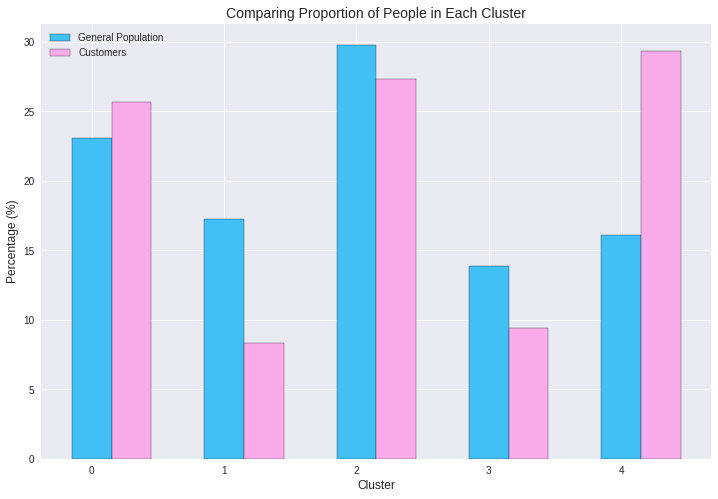

In [0]:
# Draw a plot

barWidth = 0.3
r1 = np.arange(df.shape[0])
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(12,8))

plt.bar(r1, df['General_Proportion'], width = barWidth, color = my_color[0], edgecolor = 'black', capsize=12, label='General Population')
 
# Create cyan bars
plt.bar(r2, df['Customer_Proportion'], width = barWidth, color = my_color[1], edgecolor = 'black',  capsize=12, label='Customers')
 
# general layout
plt.xlabel('Cluster', fontsize = 12)
plt.ylabel('Percentage (%)', fontsize = 12)
plt.title("Comparing Proportion of People in Each Cluster", size = 14)
plt.legend()


In [0]:
def inverse_cluster(i, cols):
  '''
  cols - 71 column names of cleaned data
  '''
  # inverse transform to its original score
  cluster = kmeans_5.cluster_centers_[i]
  cluster = pca.inverse_transform(cluster)
  cluster = scaler.inverse_transform(cluster)
  
  # to dataframe
  df = pd.DataFrame({'Score': cluster}, index = cols)
  
  return df

In [0]:
# top 5 important positive / negative features of principle component #1 
pc_1_posi = [
    'LP_STATUS_GROB_1.0', 
    'ORTSGR_KLS9',
    'HH_EINKOMMEN_SCORE',
    'EWDICHTE',
    'PLZ8_ANTG2'    
]

pc_1_nega = [
    'LP_STATUS_FEIN',
    'MOBI_REGIO',
    'WEALTH',
    'FINANZ_MINIMALIST',
    'KONSUMNAEHE'
]

In [0]:
def get_original_score_pc1(df):
  
  dict = {}

  for col in pc_1_posi:
    dict[col] = df.loc[col]['Score'].round()

  for col in pc_1_nega:
    dict[col] = df.loc[col]['Score'].round()


  return dict

In [0]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster 4

df = inverse_cluster(4, cols)
df = get_original_score_pc1(df)

df


{'EWDICHTE': 4.0,
 'FINANZ_MINIMALIST': 4.0,
 'HH_EINKOMMEN_SCORE': 4.0,
 'KONSUMNAEHE': 3.0,
 'LP_STATUS_FEIN': 9.0,
 'LP_STATUS_GROB_1.0': 0.0,
 'MOBI_REGIO': 4.0,
 'ORTSGR_KLS9': 5.0,
 'PLZ8_ANTG2': 3.0,
 'WEALTH': 4.0}

The target people might have the following features.

- They might
 - have low financial interest and average income, 
 - be houseowners,
 - be prosperous households.
- Their movement pattern is low movement.

- Their building might be located in a 500 x 500m grid cell, and
- their community might have 20,001 to 50,000 inhabitants.

- They might have high share of 3-5 family homes in the PLZ8 region.

- Their density of households per square kilometer might be 150 - 319.

In [0]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Cluster 1

df = inverse_cluster(1, cols)
df = get_original_score_pc1(df)

df

{'EWDICHTE': 5.0,
 'FINANZ_MINIMALIST': 3.0,
 'HH_EINKOMMEN_SCORE': 5.0,
 'KONSUMNAEHE': 3.0,
 'LP_STATUS_FEIN': 3.0,
 'LP_STATUS_GROB_1.0': 1.0,
 'MOBI_REGIO': 3.0,
 'ORTSGR_KLS9': 6.0,
 'PLZ8_ANTG2': 3.0,
 'WEALTH': 2.0}

The following persons might not belong to the company's target customers.

- They might

 - have  lower income and average financial interest,
 - be aspiring low-income earners,
 - be less affluent households.

- Their movement pattern might be middle movement.

- Their building might be  located in a 500 x 500m grid cell.

- Their community might have 50,001 to 100,000 inhabitants.

- They might have high share of 3-5 family homes  in the PLZ8 region.


### Discussion 3.3: Compare Customer Data to Demographics Data

Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?

Yes. The cluster assignment proportions are fairly similar between the general population and the customers. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [0]:
# Convert into HTML
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook cleaning_function.ipynb to html',
 '[NbConvertApp] Writing 303752 bytes to cleaning_function.html',
 '[NbConvertApp] Converting notebook Identify_Customer_Segments.ipynb to html',
 '[NbConvertApp] Writing 889535 bytes to Identify_Customer_Segments.html']